# Anomaly detection by Informer


## 1. Data preprocessing

In [1]:
import pandas as pd
attack = pd.read_csv("./dataset/WADI/preprocessing/wadi_attack.csv")
attack.date = pd.to_datetime(attack.date)
attack = attack.set_index('date')
attack

,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_MV_001_STATUS,1_MV_002_STATUS,...,3_MV_001_STATUS,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW
date,,,,,,,,,,,,,,,,,,,,,
2017-10-09 18:00:00,164.2108,0.536685,11.99616,482.4776,0.331213,0.001192,0,0,1.0,1.0,...,1,1,1,1,1,1,1,62.61968,1,0.390
2017-10-09 18:00:10,164.2144,0.560082,11.99769,482.4761,0.331187,0.001122,0,0,1.0,1.0,...,1,1,1,1,1,1,1,62.65199,1,0.390
2017-10-09 18:00:20,164.2146,0.558282,11.99808,482.4571,0.331268,0.001215,0,0,1.0,1.0,...,1,1,1,1,1,1,1,62.63290,1,0.390
2017-10-09 18:00:30,164.2084,0.555884,11.99602,482.4754,0.331258,0.001191,0,0,1.0,1.0,...,1,1,1,1,1,1,1,62.41118,1,0.348
2017-10-09 18:00:40,164.2020,0.532485,12.00000,482.4770,0.331161,0.001210,0,0,1.0,1.0,...,1,1,1,1,1,1,1,62.40000,1,0.360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-11 17:59:10,173.0266,0.532486,11.92058,465.7416,0.318325,0.001318,0,0,1.0,1.0,...,1,1,1,1,1,1,1,59.49293,1,0.000
2017-10-11 17:59:20,172.9642,0.530685,11.92130,465.7854,0.318499,0.001130,0,0,1.0,1.0,...,1,1,1,1,1,1,1,59.52644,1,0.000
2017-10-11 17:59:30,172.9660,0.550484,11.91955,465.8605,0.318412,0.001199,0,0,1.0,1.0,...,1,1,1,1,1,1,1,59.32690,1,0.000


In [2]:
import numpy as np
events = {
'1' : ('2017-10-09 19:25:00', '2017-10-09 19:50:10'),
'2' : ('2017-10-10 10:24:10', '2017-10-10 10:33:50'),
'3-4' : ('2017-10-10 10:55:00', '2017-10-10 11:23:50'),
'5' : ('2017-10-10 11:30:40', '2017-10-10 11:44:40'),
'6' : ('2017-10-10 13:39:30', '2017-10-10 13:50:30'),
'7' : ('2017-10-10 14:48:20', '2017-10-10 14:59:50'),
'8' : ('2017-10-10 17:40:00', '2017-10-10 17:49:30'),
'9' : ('2017-10-11 10:55:00', '2017-10-11 10:56:20'),
'10' : ('2017-10-11 11:17:50', '2017-10-11 11:31:10'),
'11' : ('2017-10-11 11:36:30', '2017-10-11 11:46:50'),
'12' : ('2017-10-11 11:59:00', '2017-10-11 12:04:50'),
'13' : ('2017-10-11 12:07:30', '2017-10-11 12:10:40'),
'14' : ('2017-10-11 12:16:00', '2017-10-11 12:25:30'),
'15' : ('2017-10-11 15:26:30', '2017-10-11 15:36:50')
}
attack['event'] = np.zeros(len(attack), dtype=int)
for event, duration in events.items():
    start, end = duration
    attack.loc[start:end, 'event'] = 1

In [3]:
attack.loc[:,'event'].sum()#/len(attack)

995

In [4]:
df = attack.iloc[:, 0:-1]
df_y = pd.DataFrame(attack.iloc[:,-1])

In [59]:
# 날짜마다 이상치 개수 계산
# 전체 이상치는 995개
# 10일 12시(정오)까지 469개(index로는 6480까지)
hap = 0
for i in range(len(df_y)):
    
    if df_y.iloc[i,0] == 1:
        hap += 1
    if hap > 469:
        print(i)
        print(df_y.iloc[i])
        break

6388
event    1
Name: 2017-10-10 11:44:40, dtype: int64


In [61]:
df_y.iloc[6480, :] # 30일까지의 개수

event    0
Name: 2017-10-10 12:00:00, dtype: int64

In [5]:
import joblib
scaler = joblib.load('./dataset/WADI/preprocessing/WADI_standard_scaler.pkl')
trans_df = scaler.transform(df)
norm_data = pd.DataFrame(data=trans_df, index=df.index, columns=df.columns, dtype=None, copy=None)

In [6]:
norm_data.describe()

,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_MV_001_STATUS,1_MV_002_STATUS,...,3_MV_001_STATUS,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW
count,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.0,17280.0,17280.000000,17280.000000,...,17280.0,17280.0,17280.0,17280.0,17280.0,17280.0,17280.0,17280.000000,17280.0,17280.000000
mean,0.626757,0.449285,1.717713,-3.005359,-0.587764,0.015457,0.0,0.0,0.004174,0.008316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.074260,0.0,0.003718
std,1.237538,5.933245,0.789526,1.286802,0.793128,1.007947,0.0,0.0,1.004873,0.092222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026631,0.0,1.044588
min,-6.622432,-6.987604,-51.383243,-21.824629,-2.107990,-0.618993,0.0,0.0,-2.846977,-1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.830725,0.0,-1.251981
25%,0.268372,-0.515739,1.590530,-3.902293,-1.290599,-0.618781,0.0,0.0,-0.609531,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.520051,0.0,-0.752054
50%,0.695289,0.133932,1.710972,-2.922606,-0.599972,-0.618684,0.0,0.0,-0.609531,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.313524,0.0,-0.002163
75%,0.849408,0.621175,1.893066,-2.003182,0.067491,1.586936,0.0,0.0,1.627915,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000134,0.0,0.361421
max,31.197117,90.993163,3.064977,-0.849976,1.019003,2.257353,0.0,0.0,1.627915,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.903816,0.0,4.042703


In [15]:
norm_data

,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_MV_001_STATUS,1_MV_002_STATUS,...,3_MV_001_STATUS,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW
date,,,,,,,,,,,,,,,,,,,,,
2017-10-09 18:00:00,-0.177379,-1.449640,2.221438,-1.015448,0.599261,-0.618678,0.0,0.0,-0.609531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.089906,0.0,-0.365746
2017-10-09 18:00:10,-0.177138,-1.053738,2.232813,-1.015552,0.598714,-0.618760,0.0,0.0,-0.609531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.084095,0.0,-0.365746
2017-10-09 18:00:20,-0.177125,-1.084203,2.235712,-1.016869,0.600407,-0.618652,0.0,0.0,-0.609531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.087528,0.0,-0.365746
2017-10-09 18:00:30,-0.177540,-1.124784,2.220397,-1.015600,0.600208,-0.618679,0.0,0.0,-0.609531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.127403,0.0,-0.461187
2017-10-09 18:00:40,-0.177969,-1.520703,2.249987,-1.015489,0.598181,-0.618657,0.0,0.0,-0.609531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.129413,0.0,-0.433918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-11 17:59:10,0.413397,-1.520685,1.659524,-2.176103,0.329155,-0.618530,0.0,0.0,-0.609531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.652222,0.0,-1.251981
2017-10-11 17:59:20,0.409216,-1.551157,1.664877,-2.173066,0.332808,-0.618751,0.0,0.0,-0.609531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.646196,0.0,-1.251981
2017-10-11 17:59:30,0.409336,-1.216157,1.651866,-2.167858,0.330991,-0.618670,0.0,0.0,-0.609531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.682081,0.0,-1.251981


In [7]:
norm_data.to_csv("./dataset/WADI/preprocessing/WADI_Attack_standard_normalised_normal.csv", mode='w')
df_y.to_csv("./dataset/WADI/preprocessing/WADI_Attack_label.csv", mode='w')

In [14]:
norm_data = pd.read_csv("./dataset/WADI/WADI_Attack_standard_normalised_normal.csv")
norm_data.date = pd.to_datetime(norm_data.date)
norm_data = norm_data.set_index('date')

In [15]:
df_y = pd.read_csv("./dataset/WADI/WADI_Attack_label.csv")
df_y.date = pd.to_datetime(df_y.date)
df_y = df_y.set_index('date')

In [ ]:
# 일단 안해줘도 될듯 
val_df = norm_data.iloc[37440:37440+6120]
test_df = norm_data.iloc[37440+6120:]

## 2.Time Series Forecasting 

In [3]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import os

In [4]:
# 12. Informerstack(lr=0.0001)
args = dotdict()

args.model = 'informerstack' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'WADI' # data
args.root_path = './dataset/WADI/preprocessing/' # root path of data file
args.data_path = 'WADI_Attack_standard_normalised_normal.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = '1_AIT_001_PV' # target feature in S or MS task
args.freq = 's' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 6*60*1 # input sequence length of Informer encoder
args.label_len = 6*30 # start token length of Informer decoder
args.pred_len = 6*10 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

# 얘네들은 feature 개수 의미하는건가?
args.enc_in = 101 # encoder input size
args.dec_in = 101 # decoder input size
args.c_out = 101 # output size

args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 16 # num of heads
#args.e_layers = 4 # 4 # num of encoder layers
args.s_layers = [4,3,2,1]
args.d_layers = 4 # 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = True # whether to output attention in ecoder
args.mix = True
args.padding = 0
#args.freq = 's'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type2'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 30
args.patience = 4
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [10]:
# Exp = Exp_Informer
# exp = Exp(args)
# setting = 'informer_SWaT_ftM_sl1080_ll720_pl360_dm512_nh8_el6_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(exp.args.checkpoints, setting)
# best_model_path = path+'/'+'checkpoint.pth'
# exp.model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [5]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import StandardScaler

from utils.tools import StandardScaler
from utils.timefeatures import time_features

import warnings
warnings.filterwarnings('ignore')

class Dataset_WADI_anomaly(Dataset):
    def __init__(self, root_path, flag='train', size=None, 
                 features='S', data_path='ETTh1.csv', 
                 target='OT', scale=False, inverse=False, timeenc=0, freq='h', cols=None, val_test_split=10000):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24*4*4
            self.label_len = 24*4
            self.pred_len = 24*4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['test', 'val']
        type_map = {'val':0, 'test':1}
        self.set_type = type_map[flag]
        
        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        
        self.root_path = root_path
        self.data_path = data_path
        self.val_test_split = val_test_split
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        border1s = [0, self.val_test_split - self.seq_len]
        border2s = [self.val_test_split, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        if self.features=='M' or self.features=='MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len 
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [6]:
from utils.metrics import metric
import numpy as np

def predict(setting, val_test='val', load=True):
        test_data, test_loader = data_set, data_loader
        
        if load:
            path = os.path.join(exp.args.checkpoints, setting)
            best_model_path = path+'/'+'checkpoint.pth'
            exp.model.load_state_dict(torch.load(best_model_path))

        exp.model.eval()
        
        preds = []
        trues = []
        
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
            if i%args.pred_len == 0 or i+1==len(test_loader):
                #print('{}/{} step'.format(i, len(test_loader)))
                pred, true = _process_one_batch(
                    test_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
                preds.append(pred.detach().cpu().numpy())
                trues.append(true.detach().cpu().numpy())

        preds = np.array(preds)
        trues = np.array(trues)
        
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # result save
        folder_path = './results/anomaly/' + setting +'/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe = metric(preds, trues)
        print('mse:{}, mae:{}'.format(mse, mae))

        np.save(folder_path+val_test+'_metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path+val_test+'_pred.npy', preds)
        np.save(folder_path+val_test+'_true.npy', trues)

        return


In [7]:
def _process_one_batch(dataset_object, batch_x, batch_y, batch_x_mark, batch_y_mark):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)

        return outputs, batch_y

In [305]:
6*60*21, 6*60*22

(7560, 7920)

In [407]:
# 13시간 굳
Data = Dataset_WADI_anomaly
timeenc = 0 if args.embed!='timeF' else 1
val_test_split = 6*60*13 # 어디를 기준으로 val, test 자를지
flag = 'test'

shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.freq # batch_size를 1로 하는게 좋긴 할듯

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    inverse=args.inverse,
    timeenc=timeenc,
    freq=freq,
    cols=args.cols,
    val_test_split=val_test_split
)
print(flag, len(data_set))
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


Exp = Exp_Informer
exp = Exp(args)
setting = 'informerstack_WADI_ftM_sl360_ll180_pl60_dm512_nh16_elNone_dl4_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0_informerstack_preprocessing2'
predict(setting, flag)
torch.cuda.empty_cache()

test 12541
Use GPU: cuda:0
test shape: (210, 1, 60, 101) (210, 1, 60, 101)
test shape: (210, 60, 101) (210, 60, 101)
mse:37048544.0, mae:524.326416015625


In [22]:
path = './results/anomaly/'+setting
val_preds = np.load(path+'/val_pred.npy')
val_trues = np.load(path+'/val_true.npy')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


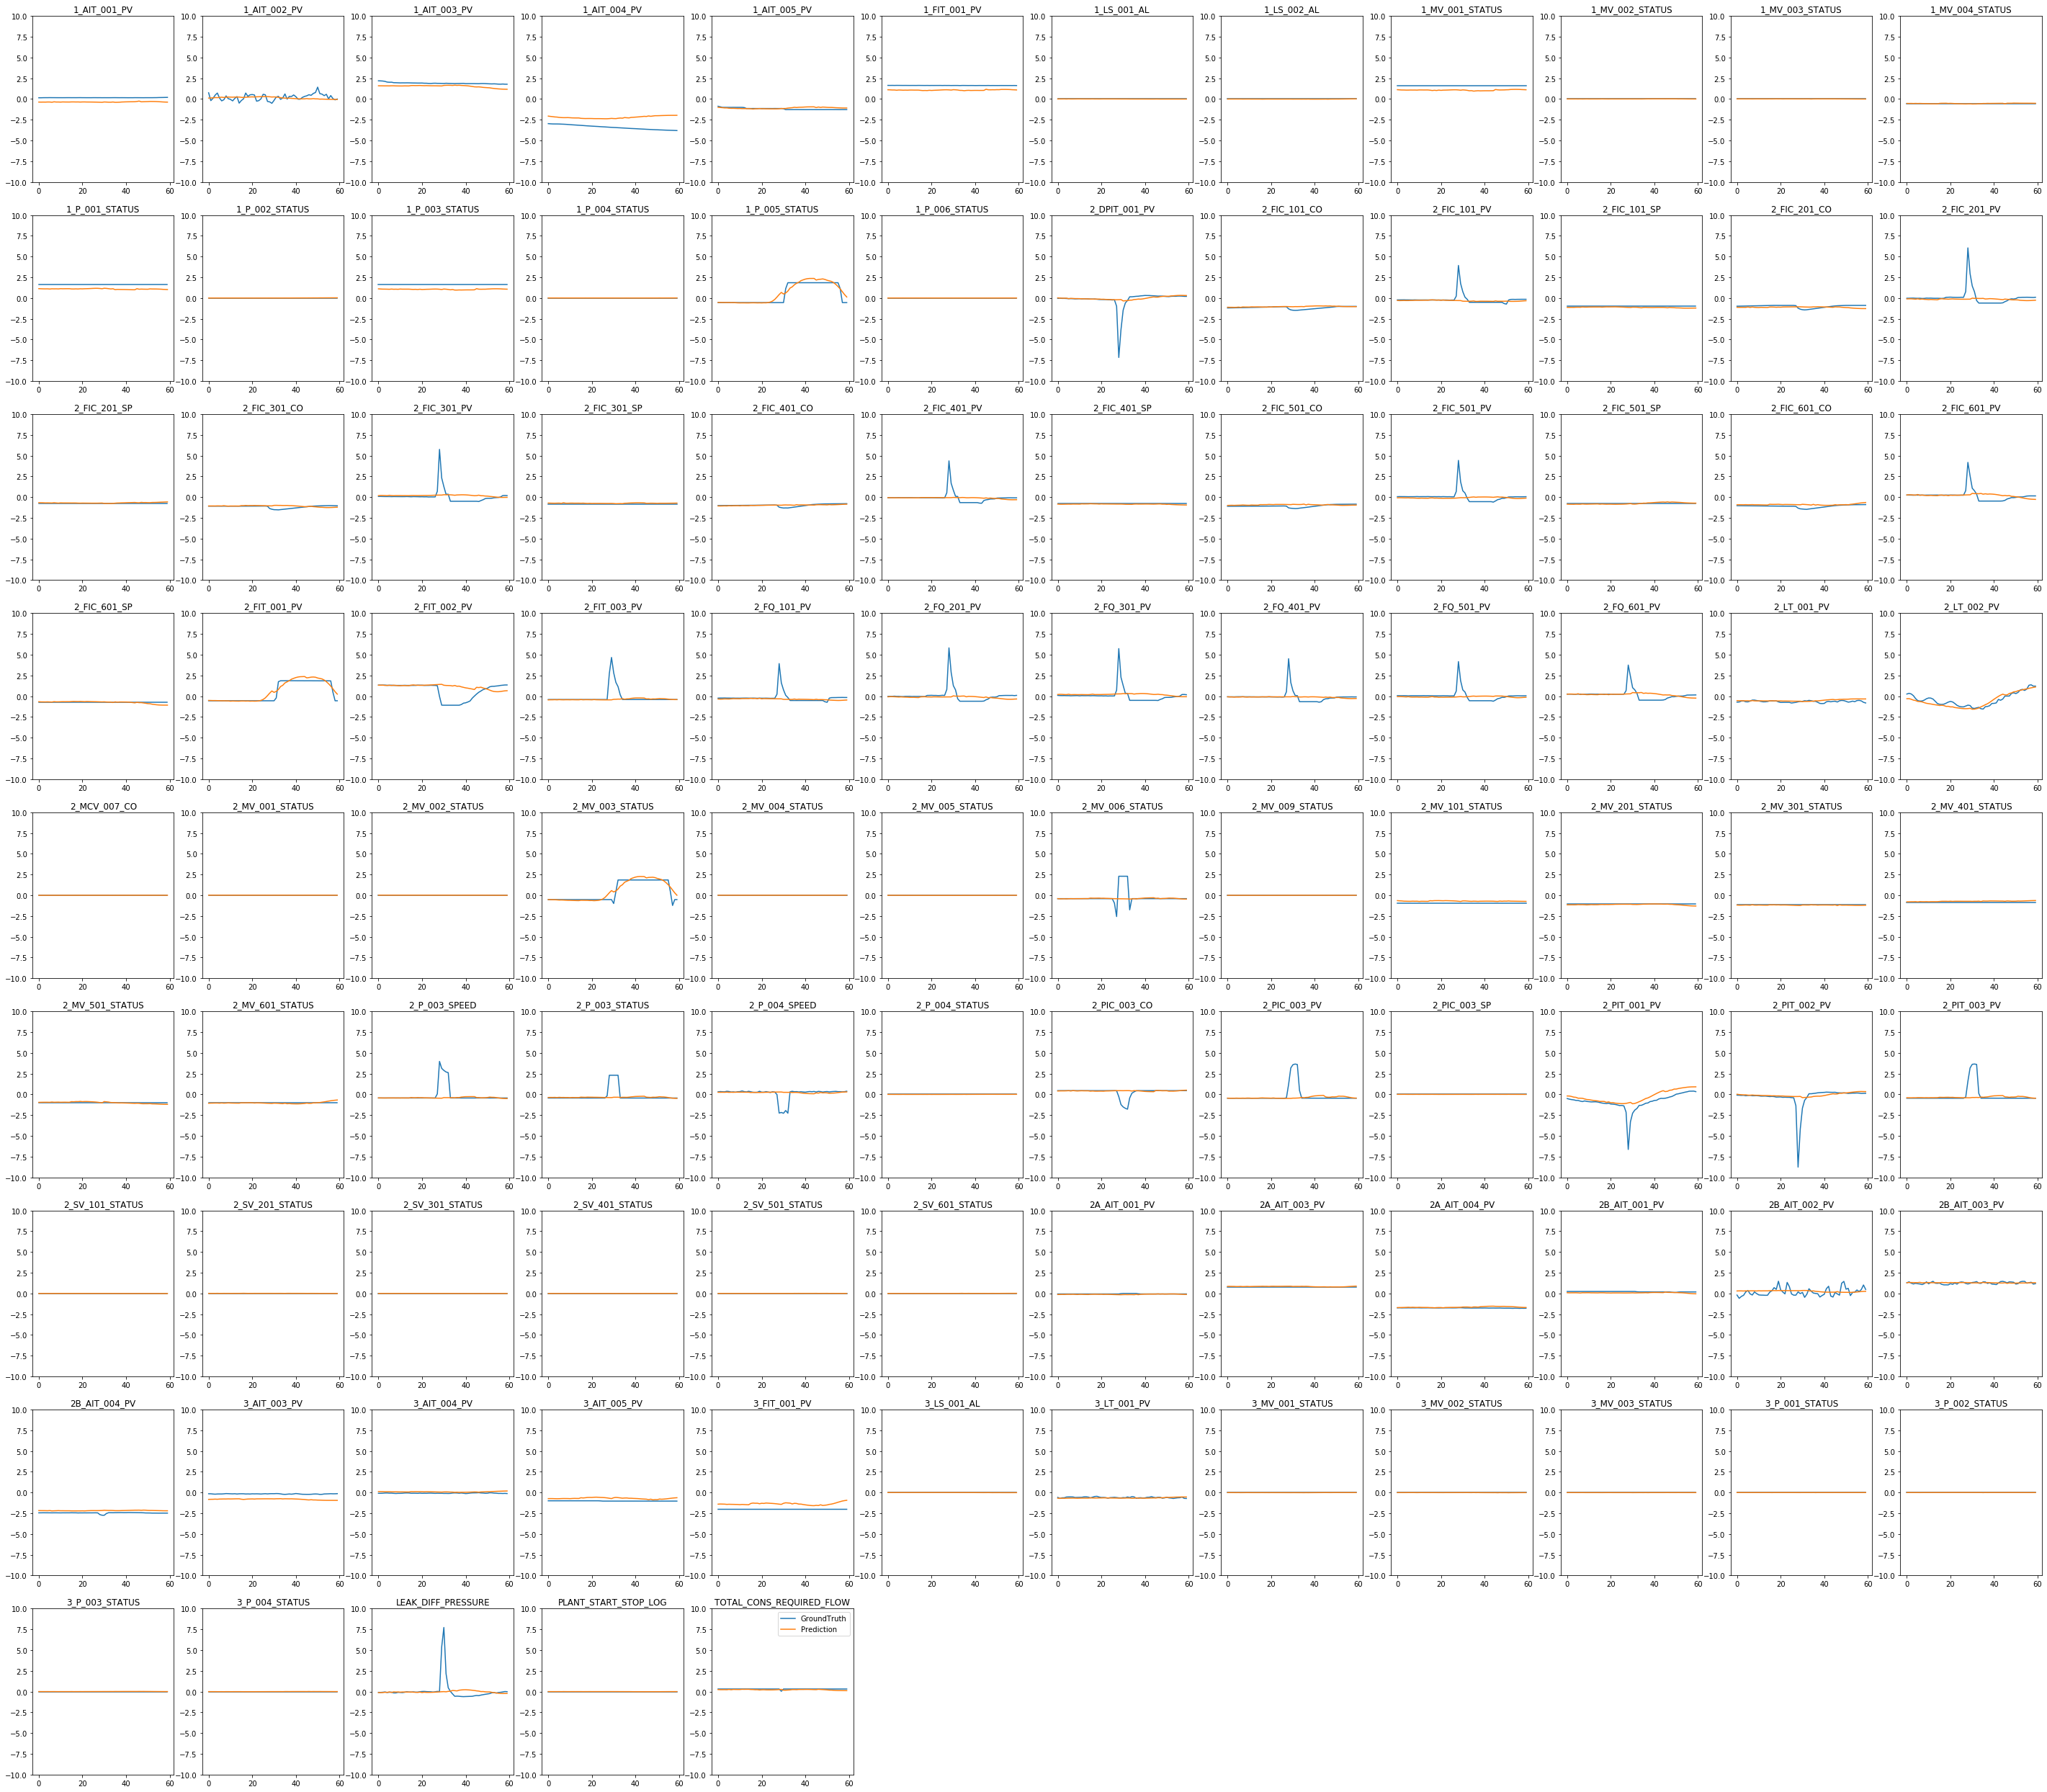

In [33]:
# StandardScaler
# lr=0.0001
# args.seq_len = 6*60*3, args.label_len = 6*60, args.pred_len = 6*30 
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))

idx = 3
 
for i in range(args.enc_in):
    plt.subplot(10, 12, i+1)
    plt.ylim([-10.0, 10.0])    
    plt.plot(val_trues[idx,:,i], label='GroundTruth')
    plt.plot(val_preds[idx,:,i], label='Prediction')
    plt.title(f'{norm_data.columns[i]}')

print(list(val_label.iloc[idx*args.pred_len:(idx+1)*args.pred_len, 0]))
plt.legend()
plt.show()

In [22]:
path = './results/anomaly/'+setting
#val_preds = np.load(path+'/val_pred.npy')
#val_trues = np.load(path+'/val_true.npy')
test_preds = np.load(path+'/test_pred.npy')
test_trues = np.load(path+'/test_true.npy')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


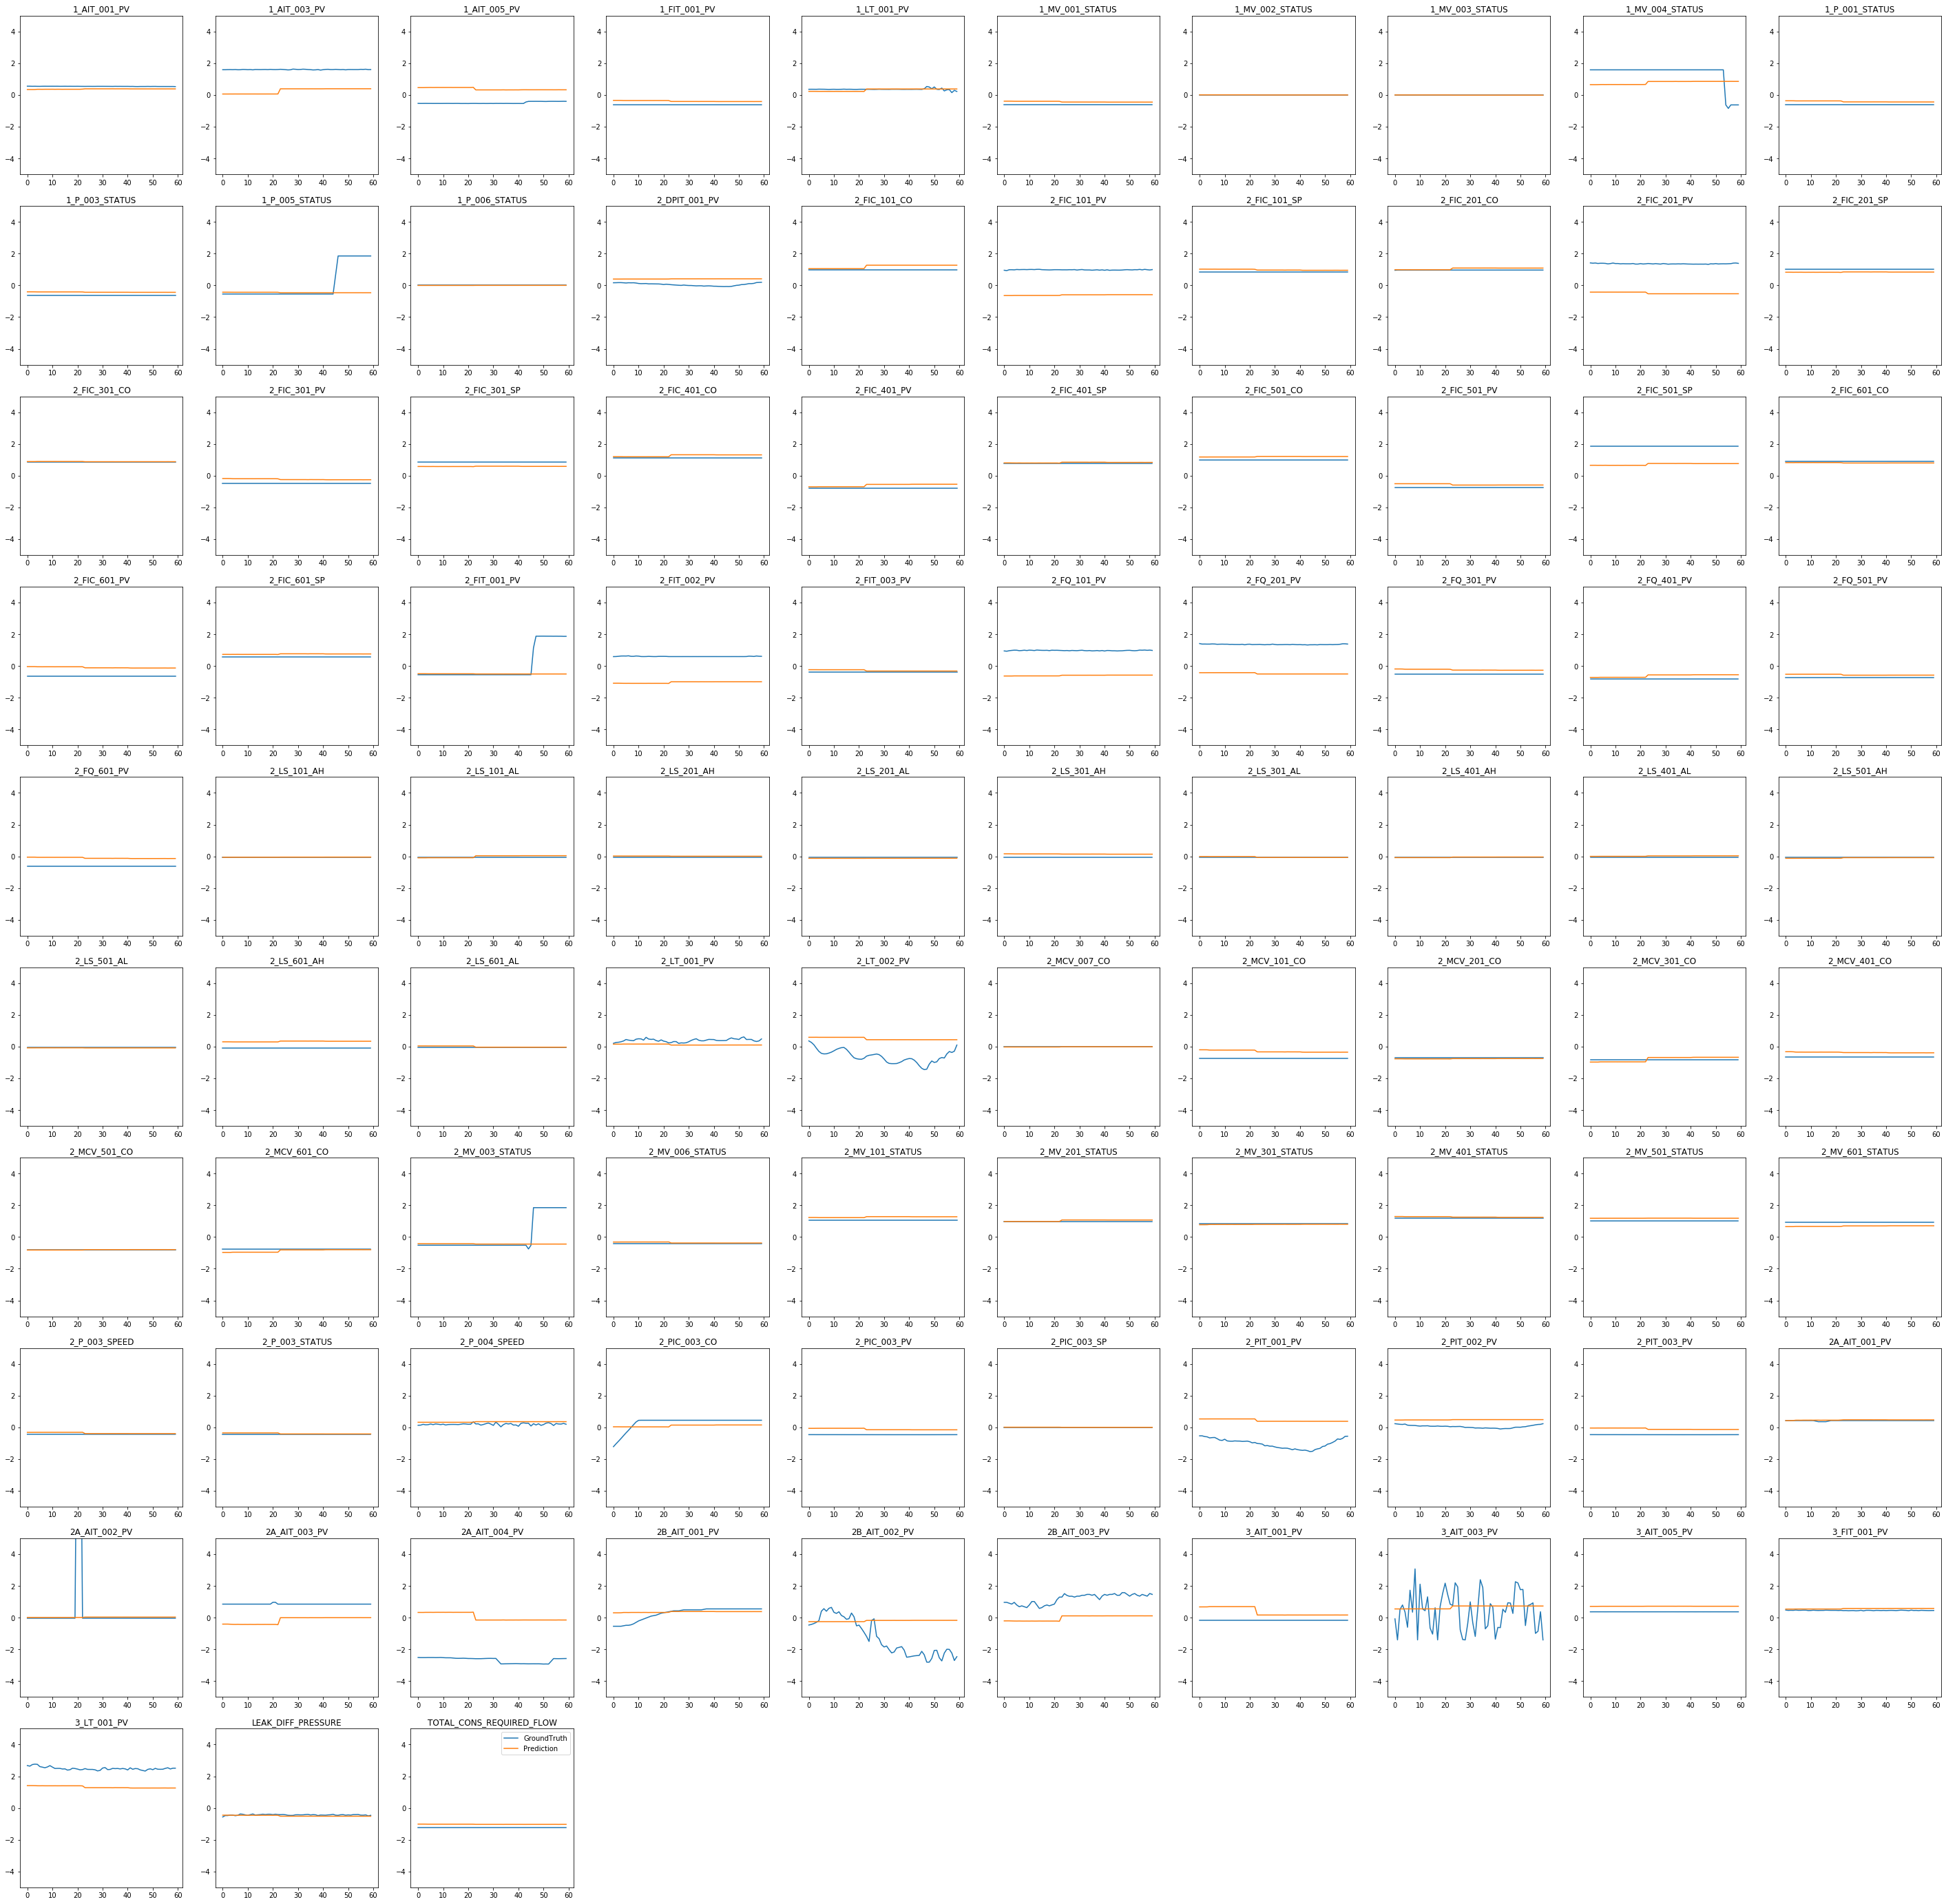

In [25]:
# StandardScaler
# lr=0.0001
# args.seq_len = 6*60*3, args.label_len = 6*60, args.pred_len = 6*30 
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))

idx = 10
 
for i in range(args.enc_in):
    plt.subplot(10, 10, i+1)
    plt.ylim([-5.0, 5.0])    
    
    plt.plot(test_trues[idx,:,i], label='GroundTruth')
    plt.plot(test_preds[idx,:,i], label='Prediction')
    plt.title(f'{norm_data.columns[i]}')

print(list(test_label.iloc[idx*60:(idx+1)*60, 0]))
plt.legend()
plt.show()

## 3. Anomaly detection

In [413]:
df_y = pd.read_csv("./dataset/WADI/preprocessing/WADI_Attack_label.csv")
df_y.date = pd.to_datetime(df_y.date)
df_y = df_y.set_index('date')

val_label = df_y[args.seq_len:val_test_split]
test_label = df_y[val_test_split:]

path = './results/anomaly/'+setting
val_preds = np.load(path+'/val_pred.npy').reshape(-1,args.c_out)
val_trues = np.load(path+'/val_true.npy').reshape(-1,args.c_out)
test_preds = np.load(path+'/test_pred.npy').reshape(-1,args.c_out)
test_trues = np.load(path+'/test_true.npy').reshape(-1,args.c_out)

val_err = np.abs(val_preds-val_trues)
test_err = np.abs(test_preds-test_trues)

val_median = np.median(val_err,axis=0)
test_median = np.median(test_err,axis=0)

val_Q1 = np.percentile(val_err, 25, axis = 0) 
val_Q3 = np.percentile(val_err, 75, axis = 0) 
val_IQR = val_Q3 - val_Q1
test_Q1 = np.percentile(test_err, 25, axis = 0) 
test_Q3 = np.percentile(test_err, 75, axis = 0) 
test_IQR = test_Q3 - test_Q1

val_a = np.abs((val_err - val_median)/val_IQR)
val_a2 = np.delete(val_a,[82],axis=1)
test_a = np.abs((test_err - test_median)/test_IQR)
test_a2 = np.delete(test_a,[82],axis=1)

#val_A = np.max(val_a, axis=1)
#test_A = np.max(test_a, axis=1)
val_A = np.max(val_a2, axis=1)
test_A = np.max(test_a2, axis=1)

In [383]:
val_a2 = np.delete(val_a,[82],axis=1)

In [384]:
val_A = np.max(val_a2, axis=1)

In [380]:
np.argmax(val_a2[-1])

33

In [331]:
val_Q1.shape

(101,)

In [172]:
val_label.shape, val_preds.shape

((8280, 1), (8280, 101))

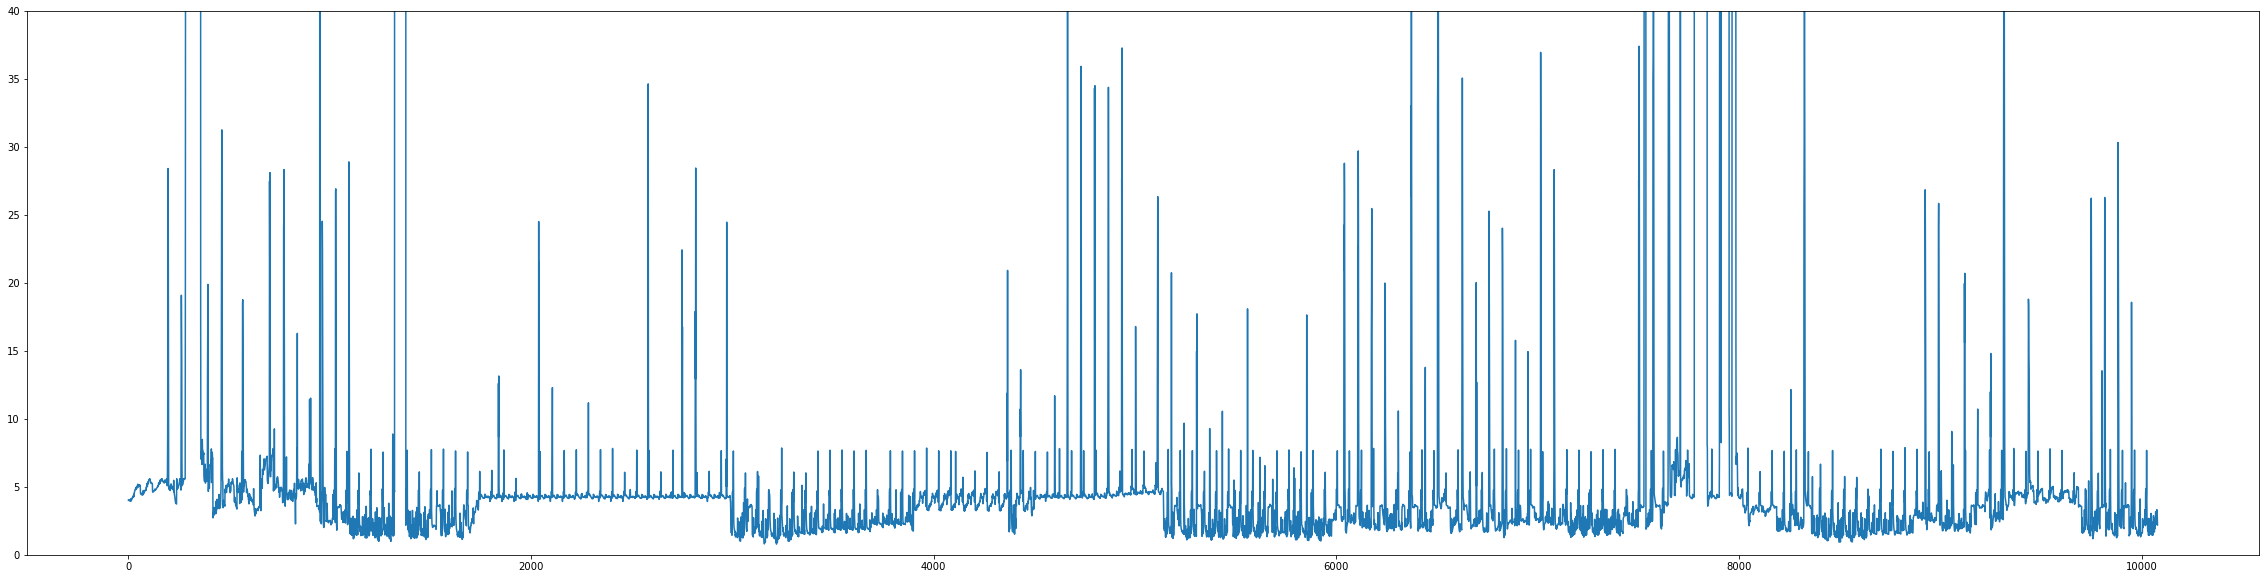

In [482]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,10))
plt.ylim([0.0, 40.0])
plt.plot(test_A)
#plt.plot(np.array(val_label))
plt.show()

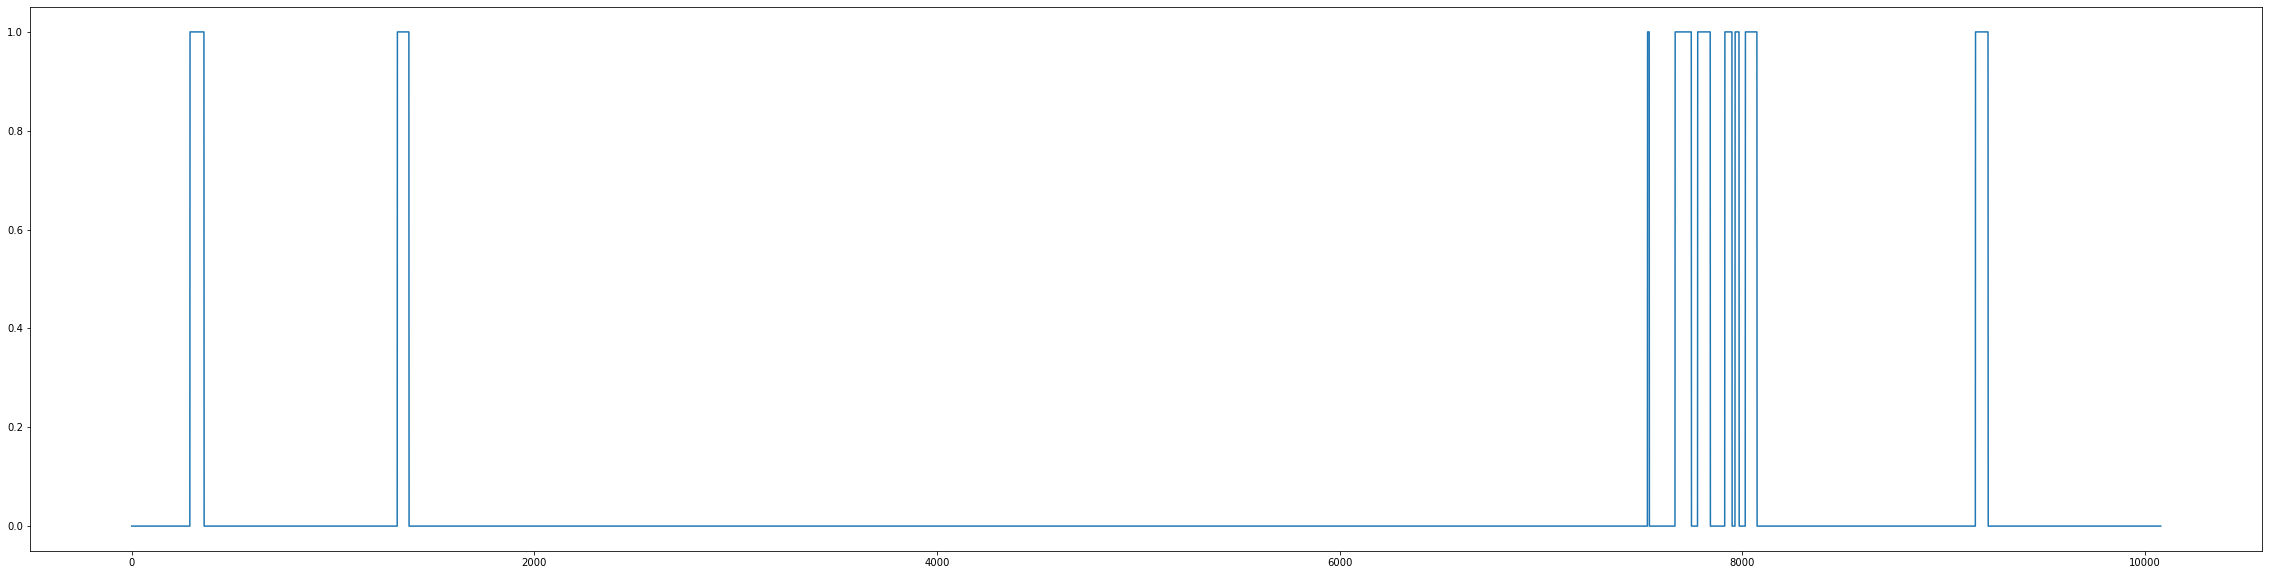

In [481]:
plt.figure(figsize=(40,10))
plt.plot(np.array(test_label))
plt.show()

### 3-1 Threshold

In [410]:
from sklearn.metrics import f1_score, precision_score, recall_score

n_threshold = 100
threshold_list = np.linspace(np.min(val_A), np.max(val_A), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)

true = list(val_label.iloc[:, 0])
max_f1 = 0
max_f1_threshold = 0
f1_list = []
for threshold in threshold_list:
    pred = list(map(int, val_A > threshold))
    f1 = f1_score(true, pred)
    f1_list.append(f1)

max_f1_threshold = threshold_list[np.array(f1_list).argmax()]
max_f1_threshold, np.array(f1_list).max()

(12.697843907420378, 0.1625615763546798)

In [401]:
true = list(test_label.iloc[:, 0])
pred = list(map(int, test_A > max_f1_threshold))
f1 = f1_score(true, pred)
recall = recall_score(true, pred)
precision = precision_score(true, pred)
f1, recall, precision

(0.4741721854304636, 0.4246737841043891, 0.5367316341829086)

In [41]:
from sklearn.metrics import f1_score

threshold = threshold_list[50]
tmp1 = list(map(int, val_A > threshold))
tmp2 = list(val_label.iloc[:, 0])
f1_score(tmp2, tmp1)

0.007952286282306162

In [ ]:
==============================================

In [1]:
# 18시간 60% 20시간 61.7%
val_test_split = 6*60*20

In [8]:
# 13시간 굳
Data = Dataset_WADI_anomaly
timeenc = 0 if args.embed!='timeF' else 1
flag = 'val'

shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.freq # batch_size를 1로 하는게 좋긴 할듯

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    inverse=args.inverse,
    timeenc=timeenc,
    freq=freq,
    cols=args.cols,
    val_test_split=val_test_split
)
print(flag, len(data_set))
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


Exp = Exp_Informer
exp = Exp(args)
setting = 'informerstack_WADI_ftM_sl360_ll180_pl60_dm512_nh16_elNone_dl4_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0_informerstack_preprocessing2'
predict(setting, flag)
torch.cuda.empty_cache()

# 13시간 굳
Data = Dataset_WADI_anomaly
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'

shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.freq # batch_size를 1로 하는게 좋긴 할듯

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    inverse=args.inverse,
    timeenc=timeenc,
    freq=freq,
    cols=args.cols,
    val_test_split=val_test_split
)
print(flag, len(data_set))
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


Exp = Exp_Informer
exp = Exp(args)
setting = 'informerstack_WADI_ftM_sl360_ll180_pl60_dm512_nh16_elNone_dl4_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0_informerstack_preprocessing2'
predict(setting, flag)
torch.cuda.empty_cache()

df_y = pd.read_csv("./dataset/WADI/preprocessing/WADI_Attack_label.csv")
df_y.date = pd.to_datetime(df_y.date)
df_y = df_y.set_index('date')

val_label = df_y[args.seq_len:val_test_split]
test_label = df_y[val_test_split:]

path = './results/anomaly/'+setting
val_preds = np.load(path+'/val_pred.npy').reshape(-1,args.c_out)
val_trues = np.load(path+'/val_true.npy').reshape(-1,args.c_out)
test_preds = np.load(path+'/test_pred.npy').reshape(-1,args.c_out)
test_trues = np.load(path+'/test_true.npy').reshape(-1,args.c_out)

val_err = np.abs(val_preds-val_trues)
test_err = np.abs(test_preds-test_trues)

val_median = np.median(val_err,axis=0)
test_median = np.median(test_err,axis=0)

val_Q1 = np.percentile(val_err, 25, axis = 0) 
val_Q3 = np.percentile(val_err, 75, axis = 0) 
val_IQR = val_Q3 - val_Q1
test_Q1 = np.percentile(test_err, 25, axis = 0) 
test_Q3 = np.percentile(test_err, 75, axis = 0) 
test_IQR = test_Q3 - test_Q1

val_a = np.abs((val_err - val_median)/val_IQR)
val_a2 = np.delete(val_a,[82],axis=1)
test_a = np.abs((test_err - test_median)/test_IQR)
test_a2 = np.delete(test_a,[82],axis=1)

#val_A = np.max(val_a, axis=1)
#test_A = np.max(test_a, axis=1)
val_A = np.max(val_a2, axis=1)
test_A = np.max(test_a2, axis=1)

from sklearn.metrics import f1_score, precision_score, recall_score

n_threshold = 100
threshold_list = np.linspace(np.min(val_A), np.max(val_A), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)

true = list(val_label.iloc[:, 0])
max_f1 = 0
max_f1_threshold = 0
f1_list = []
for threshold in threshold_list:
    pred = list(map(int, val_A > threshold))
    f1 = f1_score(true, pred)
    f1_list.append(f1)

max_f1_threshold = threshold_list[np.array(f1_list).argmax()]
max_f1_threshold, np.array(f1_list).max()

val 6781
Use GPU: cuda:0
test shape: (114, 1, 60, 101) (114, 1, 60, 101)
test shape: (114, 60, 101) (114, 60, 101)
mse:0.3827946186065674, mae:0.2634682059288025
test 10021
Use GPU: cuda:0
test shape: (168, 1, 60, 101) (168, 1, 60, 101)
test shape: (168, 60, 101) (168, 60, 101)
mse:46310668.0, mae:655.3118896484375


(23.829312876248306, 0.4649805447470817)

In [10]:
true = list(test_label.iloc[:, 0])
pred = list(map(int, test_A > max_f1_threshold))
f1 = f1_score(true, pred)
recall = recall_score(true, pred)
precision = precision_score(true, pred)
f1, recall, precision

(0.6182266009852216, 0.5480349344978166, 0.7090395480225988)